In [39]:
import geopandas
import pandas as pd
from osgeo import ogr,gdal
import os,sys
import numpy 
from tqdm import tqdm
from shapely.wkb import loads
import pygeos
import matplotlib.pyplot as plt
import openpyxl
import re
import pygeos
import geopandas as gpd
import pyproj
from tqdm import tqdm
from pathlib import Path
import itertools

from simplify import *
from flow_model import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 


def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    pygeos_geo = pygeos.from_wkt(feature.geometry().ExportToWkt())
                    if pygeos_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(pygeos_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}

def roads(osm_path):
    """
    Function to extract road linestrings from OpenStreetMap  
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.        
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique road linestrings.
    """   
    return retrieve(osm_path,'lines',['highway']) 
 
#def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.
    """ 
    #return retrieve(osm_path,'lines',['railway','service'],**{"service":[" IS NOT NULL"]})

def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique land-use polygons.
    """ 
    return retrieve(osm_path,'lines',['railway','service'])

def train_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway', 'name'],**{'railway':["='station'"]}))
            #(retrieve(osm_path,'points',['railway'],**{'railway':["='station'"]}))
            #(retrieve(osm_path,'points',['man_made'],**{'man_made':["='communications_tower'"]})).rename(columns={'man_made': 'asset'})

def subway_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway', 'name'],**{'railway':["='subway_entrance'"]}))     # useless

def tram_stations(osm_path):
    """
    Function to extract big communication tower nodes from OpenStreetMap. See detailed information big communication towers: https://wiki.openstreetmap.org/wiki/Tag:man_made%3Dcommunications_tower   
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all unique big communication tower nodes.
    """   
    
    return (retrieve(osm_path,'points',['railway', 'name'],**{'railway':["='tram_stop'"]}))

In [3]:
osm_data = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"

<AxesSubplot: >

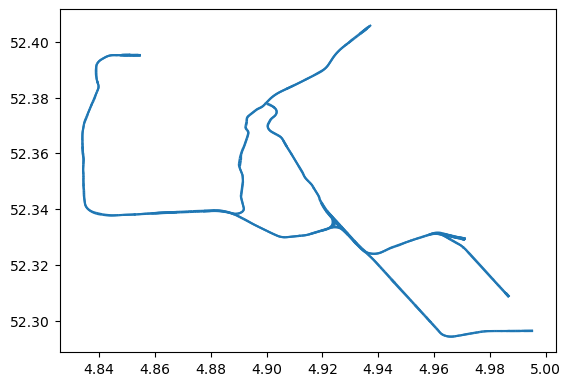

In [4]:
df_railway = railway(osm_data)
subway = df_railway.loc[df_railway.railway == 'subway']
subway.plot()

In [5]:
df_subway = pd.DataFrame(subway.copy())
df_subway.geometry = pygeos.from_shapely(df_subway.geometry)

In [88]:
def prepare_network(df_subway):

    # create mini simplified network and graph of network
    net = Network(edges=df_subway)

    # add nodes to the network
    net = add_endpoints(net)

    # split edges at new nodes
    net = split_edges_at_nodes(net)

    # readd or remove points based on split
    net = add_endpoints(net)

    # give nodes and edges an id
    net = add_ids(net)

    # add topology (Geometry) if still missing
    net = add_topology(net)    

    # add degree
    net.nodes['degree'] = calculate_degree(net)

    # merge edges with degree two
    net = merge_edges(net)

    # remove duplicate edges
    net.edges = drop_duplicate_geometries(net.edges, keep='first') 

    # reset ids based on previous fixes
    net = reset_ids(net) 

    net = add_distances(net)
    net = merge_multilinestrings(net)
    net = add_travel_time(net)
    
    return net.edges,net.nodes

In [89]:
edges,nodes = prepare_network(df_subway)

topology: 100%|████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 3107.73it/s]


In [90]:
edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time
0,23157994,"LINESTRING (4.922 52.338, 4.922 52.338, 4.923 ...",subway,NaN,0,294,20,858.377718,0.042919
1,23189033,"LINESTRING (4.846 52.395, 4.847 52.395, 4.847 ...",subway,NaN,1,115,120,237.962864,0.011898
2,23189039,"LINESTRING (4.839 52.386, 4.839 52.386, 4.839 ...",subway,NaN,2,200,115,1320.099057,0.066005
3,23189059,"LINESTRING (4.837 52.377, 4.837 52.378, 4.837 ...",subway,NaN,3,172,201,902.754616,0.045138
4,23189063,"LINESTRING (4.839 52.385, 4.84 52.385, 4.84 52...",subway,NaN,4,191,173,850.965721,0.042548
...,...,...,...,...,...,...,...,...,...
387,1061085945,"LINESTRING (4.922 52.339, 4.922 52.338, 4.922 ...",subway,NaN,387,198,294,34.811758,0.001741
388,1131538376,"LINESTRING (4.921 52.339, 4.921 52.34, 4.921 5...",subway,NaN,388,64,58,348.667904,0.017433
389,1131538382,"LINESTRING (4.922 52.339, 4.921 52.34, 4.921 5...",subway,NaN,389,97,98,350.467868,0.017523
390,1131538383,"LINESTRING (4.92 52.342, 4.92 52.342, 4.92 52....",subway,NaN,390,98,136,307.079253,0.015354


<AxesSubplot: >

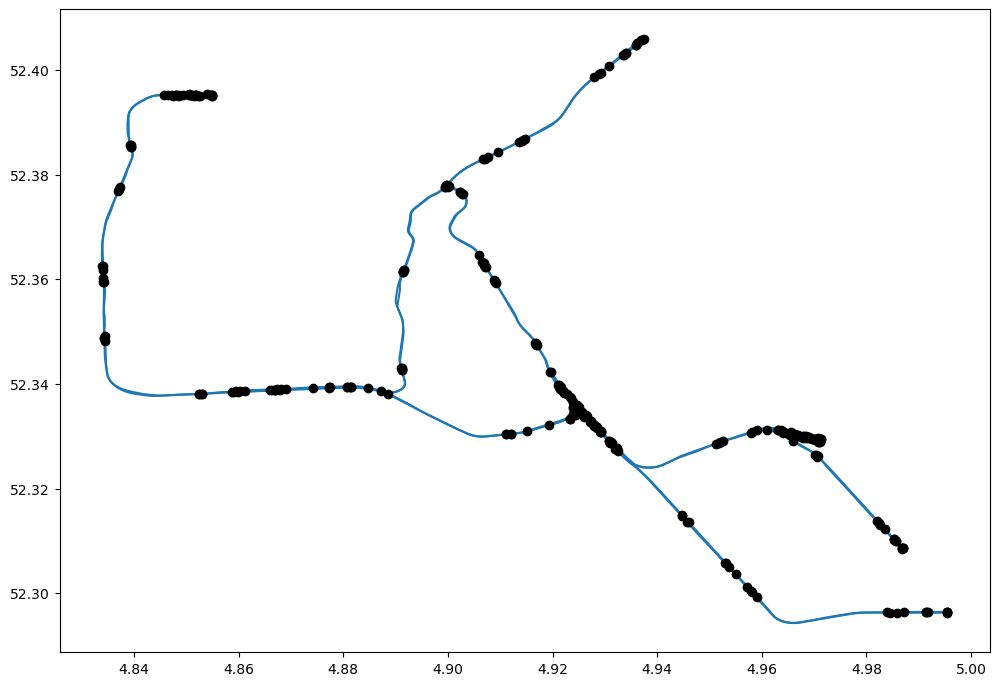

In [10]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(nodes.copy()).plot(ax=ax,color='black',zorder=1)

In [11]:
gpd.GeoDataFrame(edges.copy()).to_file('edges_metro_amsterdam.gpkg',driver='GPKG')
gpd.GeoDataFrame(nodes.copy()).to_file('nodes_metro_amsterdam.gpkg',driver='GPKG')

In [12]:
edges['weights'] = edges['distance'].astype(int)

In [13]:
od = edges[['from_id', 'to_id', 'weights']]
od

,from_id,to_id,weights
0,294,20,858
1,115,120,237
2,200,115,1320
3,172,201,902
4,191,173,850
...,...,...,...
387,198,294,34
388,64,58,348
389,97,98,350
390,98,136,307


In [14]:
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b) 

edges['to_from'] = list(zip(edges.from_id,edges.to_id))
edges['from_to'] = list(zip(edges.to_id,edges.from_id))

In [15]:
edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
0,23157994,"LINESTRING (4.922 52.338, 4.922 52.338, 4.923 ...",subway,NaN,0,294,20,858.377718,0.042919,858,"(294, 20)","(20, 294)"
1,23189033,"LINESTRING (4.846 52.395, 4.847 52.395, 4.847 ...",subway,NaN,1,115,120,237.962864,0.011898,237,"(115, 120)","(120, 115)"
2,23189039,"LINESTRING (4.839 52.386, 4.839 52.386, 4.839 ...",subway,NaN,2,200,115,1320.099057,0.066005,1320,"(200, 115)","(115, 200)"
3,23189059,"LINESTRING (4.837 52.377, 4.837 52.378, 4.837 ...",subway,NaN,3,172,201,902.754616,0.045138,902,"(172, 201)","(201, 172)"
4,23189063,"LINESTRING (4.839 52.385, 4.84 52.385, 4.84 52...",subway,NaN,4,191,173,850.965721,0.042548,850,"(191, 173)","(173, 191)"
...,...,...,...,...,...,...,...,...,...,...,...,...
387,1061085945,"LINESTRING (4.922 52.339, 4.922 52.338, 4.922 ...",subway,NaN,387,198,294,34.811758,0.001741,34,"(198, 294)","(294, 198)"
388,1131538376,"LINESTRING (4.921 52.339, 4.921 52.34, 4.921 5...",subway,NaN,388,64,58,348.667904,0.017433,348,"(64, 58)","(58, 64)"
389,1131538382,"LINESTRING (4.922 52.339, 4.921 52.34, 4.921 5...",subway,NaN,389,97,98,350.467868,0.017523,350,"(97, 98)","(98, 97)"
390,1131538383,"LINESTRING (4.92 52.342, 4.92 52.342, 4.92 52....",subway,NaN,390,98,136,307.079253,0.015354,307,"(98, 136)","(136, 98)"


# Shortest path test1

## Creat graph database for subway lines of Amsterdam

In [16]:
import networkx as nx

In [17]:
nodes_list = nodes.iloc[:,2].tolist()

In [18]:
edges_list = []
for i, row in od.iterrows():
    weight_dict = {"weight": row[2]}
    tuple_row = (row[0], row[1], weight_dict)
    edges_list.append(tuple_row)

In [19]:
G = nx.Graph()
G.add_nodes_from(nodes_list)
G.add_edges_from(edges_list)

## Give random start and end points of Amsterdam, create the shortest subway route for them

In [54]:
nodes

,geometry,degree,id
0,POINT (4.853 52.338),3,0
1,POINT (4.958 52.331),3,1
2,POINT (4.987 52.309),1,2
3,POINT (4.97 52.33),4,3
4,POINT (4.97 52.329),3,4
...,...,...,...
292,POINT (4.852 52.395),3,292
293,POINT (4.855 52.395),1,293
294,POINT (4.922 52.338),3,294
295,POINT (4.922 52.338),3,295


In [60]:
coordinate = (4.978, 52.361)

In [77]:
def find_nearest_node(coordinate, nodes):
    """
    Find the nearest node to a given coordinate or geometry in a GeoDataFrame of nodes.

    Args:
    - coordinate: a tuple of longitude and latitude (in decimal degrees) or a PyGEOS geometry object representing the location to search from
    - nodes: a GeoDataFrame containing nodes with a 'geometry' column representing their coordinates as PyGEOS Point objects
    
    Returns:
    - a GeoDataFrame containing the nearest node to the input coordinate or geometry

    Example:
    >>> import geopandas
    >>> from shapely.geometry import Point
    >>> from pygeos import Geometry
    >>> nodes = geopandas.read_file('nodes.shp')
    >>> coordinate = (-122.3, 47.6)
    >>> find_nearest_node(coordinate, nodes)
         id                      geometry
    1234  1234  POINT (-122.29675 47.59605)

    Note: This function requires the PyGEOS and STRtree libraries to be installed.
    """
    # Build an STRtree index of the nodes' geometries for efficient nearest-neighbor search
    node_tree = pygeos.STRtree(nodes.geometry)
    
    # Find the nearest node to the input coordinate or geometry using the STRtree index
    if isinstance(coordinate, tuple):
        find_nearest = node_tree.nearest(pygeos.points(coordinate))
    elif isinstance(coordinate, pygeos.lib.Geometry):
        find_nearest = node_tree.nearest(coordinate)
    
    # Return the node from the nodes GeoDataFrame that corresponds to the nearest index
    return nodes.iloc[find_nearest[1]]

In [78]:
find_nearest_node(coordinate,nodes)

,geometry,degree,id
45,POINT (4.971 52.33),1,45


In [79]:
find_nearest_node(pygeos.points(coordinate),nodes)

,geometry,degree,id
45,POINT (4.971 52.33),1,45


In [21]:
s = int(input("enter the id of start node: "))
e = int(input("enter the id of end node: "))

enter the id of start node:  66
enter the id of end node:  44


In [82]:
def shortest_path(G,start_point,end_point,weight="weight"):
    
    path_s_e = nx.shortest_path(G, source = start_point, target = end_point, weight = weight)
    
    print(f"Shortest path from {s} to {e}: ", path_s_e)
    
    return path_s_e

In [84]:
path_s_e = shortest_path(G,66,44,weight="weight")

Shortest path from 66 to 44:  [66, 68, 110, 160, 123, 146, 140, 1, 72, 161, 287, 83, 5, 74, 93, 94, 44]


In [23]:
length_s_e = nx.shortest_path_length(G, source = s, target = e, weight = "weight")
print(f"Length of the shortest path from {s} to {e}: ", length_s_e)

Length of the shortest path from 66 to 44:  4262


In [24]:
short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]    

In [25]:
short_path_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to
12,23208201,"LINESTRING (4.958 52.331, 4.958 52.331, 4.958 ...",subway,NaN,12,1,140,1051.741202,0.052587,1051,"(1, 140)","(140, 1)"
13,23208296,"LINESTRING (4.982 52.313, 4.982 52.313, 4.983 ...",subway,NaN,13,123,160,42.383969,0.002119,42,"(123, 160)","(160, 123)"
24,24343641,"LINESTRING (4.967 52.33, 4.967 52.33)",subway,yard,24,74,93,20.694861,0.001035,20,"(74, 93)","(93, 74)"
58,89755643,"LINESTRING (4.97 52.326, 4.971 52.326)",subway,None,58,140,146,46.246142,0.002312,46,"(140, 146)","(146, 140)"
86,160503105,"LINESTRING (4.968 52.33, 4.967 52.33, 4.967 52...",subway,yard,86,94,44,366.033780,0.018302,366,"(94, 44)","(44, 94)"
135,166152578,"LINESTRING (4.971 52.326, 4.971 52.326, 4.971 ...",subway,NaN,135,146,123,1627.086262,0.081354,1627,"(146, 123)","(123, 146)"
138,166161649,"LINESTRING (4.986 52.31, 4.985 52.31)",subway,yard,138,66,68,30.002982,0.001500,30,"(66, 68)","(68, 66)"
161,178856714,"LINESTRING (4.958 52.331, 4.958 52.331, 4.958 ...",subway,yard,161,1,72,224.363055,0.011218,224,"(1, 72)","(72, 1)"
162,178856714,"LINESTRING (4.961 52.331, 4.961 52.331, 4.962 ...",subway,yard,162,72,161,319.195656,0.015960,319,"(72, 161)","(161, 72)"
163,178856714,"LINESTRING (4.965 52.33, 4.966 52.33)",subway,yard,163,161,287,19.408536,0.000970,19,"(161, 287)","(287, 161)"


<AxesSubplot: >

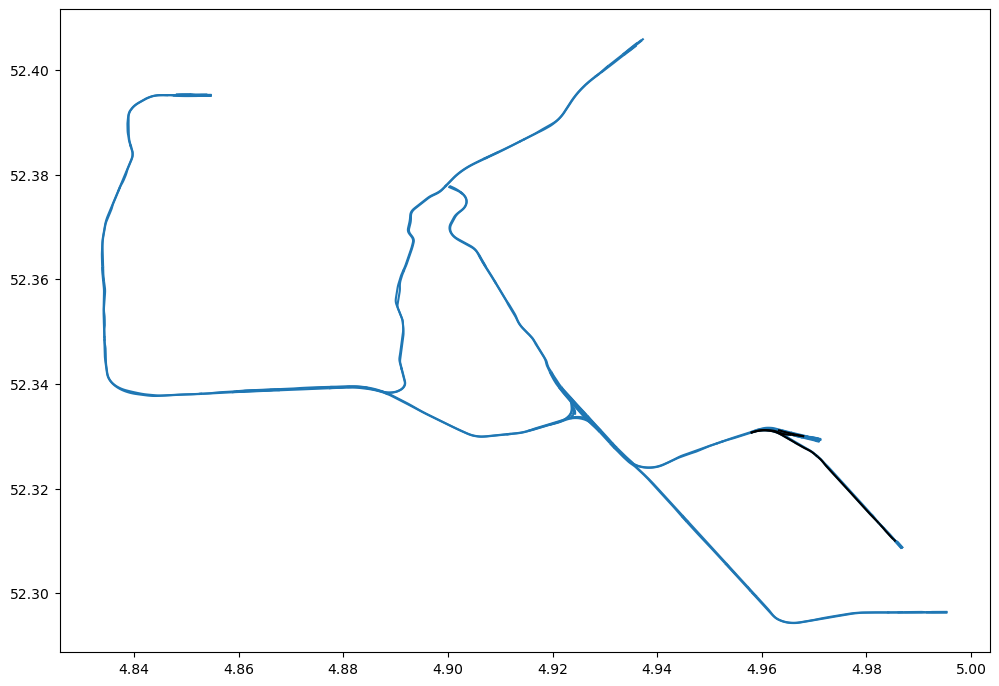

In [26]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))


gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(short_path_edges.copy()).plot(ax=ax,color='black',zorder=1)

In [27]:
short_path_edges['linewidth'] = short_path_edges['weights'].apply(lambda x: np.ceil(x * 0.01 / 2))
short_path_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,linewidth
12,23208201,"LINESTRING (4.958 52.331, 4.958 52.331, 4.958 ...",subway,NaN,12,1,140,1051.741202,0.052587,1051,"(1, 140)","(140, 1)",6.0
13,23208296,"LINESTRING (4.982 52.313, 4.982 52.313, 4.983 ...",subway,NaN,13,123,160,42.383969,0.002119,42,"(123, 160)","(160, 123)",1.0
24,24343641,"LINESTRING (4.967 52.33, 4.967 52.33)",subway,yard,24,74,93,20.694861,0.001035,20,"(74, 93)","(93, 74)",1.0
58,89755643,"LINESTRING (4.97 52.326, 4.971 52.326)",subway,None,58,140,146,46.246142,0.002312,46,"(140, 146)","(146, 140)",1.0
86,160503105,"LINESTRING (4.968 52.33, 4.967 52.33, 4.967 52...",subway,yard,86,94,44,366.033780,0.018302,366,"(94, 44)","(44, 94)",2.0
135,166152578,"LINESTRING (4.971 52.326, 4.971 52.326, 4.971 ...",subway,NaN,135,146,123,1627.086262,0.081354,1627,"(146, 123)","(123, 146)",9.0
138,166161649,"LINESTRING (4.986 52.31, 4.985 52.31)",subway,yard,138,66,68,30.002982,0.001500,30,"(66, 68)","(68, 66)",1.0
161,178856714,"LINESTRING (4.958 52.331, 4.958 52.331, 4.958 ...",subway,yard,161,1,72,224.363055,0.011218,224,"(1, 72)","(72, 1)",2.0
162,178856714,"LINESTRING (4.961 52.331, 4.961 52.331, 4.962 ...",subway,yard,162,72,161,319.195656,0.015960,319,"(72, 161)","(161, 72)",2.0
163,178856714,"LINESTRING (4.965 52.33, 4.966 52.33)",subway,yard,163,161,287,19.408536,0.000970,19,"(161, 287)","(287, 161)",1.0


<AxesSubplot: >

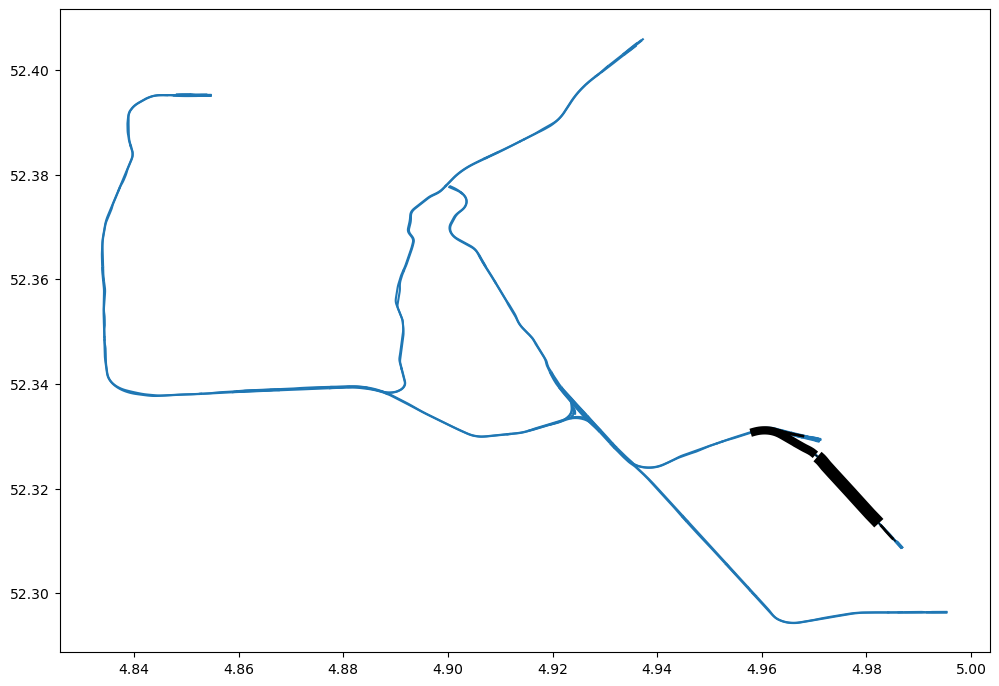

In [28]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

gpd.GeoDataFrame(edges.copy()).plot(ax=ax,zorder=0)
gpd.GeoDataFrame(short_path_edges.copy()).plot(ax=ax,color='black',zorder=1,linewidth=short_path_edges['linewidth'])

##### 1.next step 1 如何把这一块选路线改成自动化的？？？？   输入你想知道的线路得到路线图 √
##### 2.next step 2 假设任意一个位置坐标，找到edges 里面最近的点设为起点，把预定到达地最近的点设为重点，实现它就能在绘出的图上自动标注出路线起点终点？？？？

##### 3.nest thinking怎么自动实现某条线路丢失后的最短路？？？

# Get route and length of one shortest path  
(get answers with NaN because of overlooking the question of directions __ *edges* without directions, *p20to6* have one-way direction)

In [ ]:
p20to6 = nx.shortest_path(G, source = 20, target = 6, weight = "weight")
length20to6 = nx.shortest_path_length(G, source = 20, target = 6, weight = "weight")
print("Shortest path from 20 to 6: ", p20to6)
print("Length of the shortest path from 20 to 6: ", length20to6)

In [ ]:
p20to6_fromid = p20to6
p20to6_toid = p20to6_fromid[1:]
p20to6_idlist = [[p20to6_fromid[i], p20to6_toid[i]] for i in range(len(p20to6_toid))]
p20to6_idlist

In [ ]:
p20to6id_path = pd.DataFrame(p20to6_idlist, columns = ['from_id', 'to_id'])
#print(p20to6id_path)
p20to6id_edge = pd.merge(p20to6id_path, edges[['id', 'from_id', 'to_id', 'weights']], on = ['from_id', 'to_id'], how = 'left')
p20to6id_edge

In [ ]:
p1to6 = nx.shortest_path(G, source = 1, target = 6, weight = "weight")
length1to6 = nx.shortest_path_length(G, source = 1, target = 6, weight = "weight")
print("Shortest path from 1 to 6: ", p1to6)
print("Length of the shortest path from 1 to 6: ", length1to6)

In [ ]:
p1to6_fromid = p1to6
p1to6_toid = p1to6_fromid[1:]
p1to6_idlist = [[p1to6_fromid[i], p1to6_toid[i]] for i in range(len(p1to6_toid))]
p1to6_idlist

In [ ]:
p1to6id_path = pd.DataFrame(p1to6_idlist, columns = ['from_id', 'to_id'])
print(p1to6id_path)

In [ ]:
p1to6id_edge = pd.merge(p1to6id_path, edges[['id', 'from_id', 'to_id', 'weights']], on = ['from_id', 'to_id'], how = 'left')
p1to6id_edge

# Strive data from OSM to excel

In [ ]:
osm_data = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"

In [ ]:
train_stations(osm_data)  

In [ ]:
df_trainsta = train_stations(osm_data)

In [ ]:
df_trainsta.plot() # why it draw a graph according to the coordinates?

In [ ]:
df_trainsta.to_excel('./train_stations.xlsx',header = True, index = False,sheet_name = 'mydata')        # subway station nodes

In [ ]:
railway(osm_data)

In [ ]:
df_railway = railway(osm_data)

In [ ]:
subway = df_railway.loc[df_railway.railway == 'subway']
subway.plot()

In [ ]:
subway.to_excel('./subway.xlsx',header = True, index = False,sheet_name = 'mydata')          # subway edges

# Creat amsterdam subway manually with NetworkX 

In [ ]:
# Try to draw the nodes and lines together and get od pairs      Didn't work, try another way with module —— simplify
'''df1 = pd.read_excel(r'./subway1.xlsx','sheet1')
df2 = pd.read_excel(r'./subway2.xlsx','sheet1')
frames = [df1,df2]
df = pd.concat(frames)
df.to_excel('./subwayall.xlsx',header = True, index = False)
df.plot()   '''

In [ ]:
import networkx as nx

In [ ]:
df = pd.read_excel(r'./amsub.xlsx','od_net_undirected')

In [ ]:
G = nx.from_pandas_edgelist(df, 'origin', 'destination', create_using = nx.Graph()) # unweighted

In [ ]:
nx.draw(G, node_size = 500, node_color = 'yellow', with_labels = True)

In [ ]:
WG = nx.from_pandas_edgelist(df, 'origin', 'destination','weight', create_using = nx.Graph()) # weighted - random running time as weight 

In [ ]:
edge_width = nx.get_edge_attributes(WG, "weight")
nx.draw(WG, node_size = 500, node_color = 'pink', with_labels = True, width = list(edge_width.values()))

##### 1.retrive *name* together with *osm_id* *railway* *geometry*   √ 
##### 2.automatically get OD pair (by drawing nodes and edges together)    how? —— using simplify module √
##### 3.*train_stations(osm_data)* contains subway stations and railway stations， need to seperate them and get the unretrived station有时候因为站点是线条或区域格式而提取不到  —— don't need to do it now with the simplify module    √
##### 4.how to draw different routes